In [1]:
import pandas as pd
import geopandas

In [47]:
file_path = 'Datasets/Flood RIsk/riskPolygonsInVietnam.shp'
floodrisk = geopandas.read_file(file_path)

In [ ]:
file_path = 'Datasets/Population_VNM_2020_1km_Aggregated_UNadj.csv'
pop = pd.read_csv(file_path)

In [3]:
pop = geopandas.GeoDataFrame(
    pop, geometry=geopandas.points_from_xy(pop.X, pop.Y))

In [4]:
pop.rename(columns={'X':'x','Y':'y'},inplace=True)

In [5]:
vietnamBoundaries = geopandas.read_file('Datasets/Vietnam_Administrative_Boundaries.geojson')

In [6]:
hospitals = geopandas.read_file('20210930_hospitalsNodesMerge0.shp')

In [7]:
hospitals

,full_id,osm_id,osm_type,amenity,building,name,type,addr_city,addr_distr,addr_house,...,index_righ,FID_Raster,Id,gridcode,FID_countr,country,SUM_Shape_,Shape_Leng,Shape_Area,geometry
0,w538534203,538534203,way,hospital,None,B???nh vi???n m???t T??y Nguy??n,None,None,None,309,...,None,None,None,0.0,None,None,None,None,None,POINT (108.06167 12.69464)
1,w557042925,557042925,way,hospital,None,nh?? thu???c Tu???n Th???o,None,None,None,None,...,None,None,None,0.0,None,None,None,None,None,POINT (105.90519 18.33134)
2,w557046553,557046553,way,hospital,None,nh?? thu???c ????ng ????,None,None,None,None,...,None,None,None,0.0,None,None,None,None,None,POINT (105.90490 18.33239)
3,w557252001,557252001,way,hospital,None,None,None,None,None,None,...,None,None,None,0.0,None,None,None,None,None,POINT (105.91265 18.32273)
4,w571535898,571535898,way,hospital,None,Trung t??m Y t??? huy???n Kon Pl??ng,None,None,None,None,...,None,None,None,0.0,None,None,None,None,None,POINT (108.29386 14.59722)
5,w631548583,631548583,way,hospital,None,B???nh vi???n ??a khoa D???u Gi??y,None,None,None,None,...,None,None,None,0.0,None,None,None,None,None,POINT (107.13899 10.95160)
6,w689686672,689686672,way,hospital,None,B???nh Vi???n ??a Khoa Th??nh Ph??? Pleiku,None,None,None,None,...,None,None,None,0.0,None,None,None,None,None,POINT (107.99059 13.97936)
7,w731884707,731884707,way,hospital,None,B???nh vi???n T??m th???n T???nh B?? R???a - V...,None,None,None,None,...,None,None,None,0.0,None,None,None,None,None,POINT (107.23567 10.58535)
8,n4663404099,4663404099,node,hospital,None,B?nh vi?n H??ng S?n,None,None,None,None,...,None,None,None,0.0,None,None,None,None,None,POINT (105.42688 18.51586)
9,n5740113949,5740113949,node,hospital,None,B?nh Vi?n 211 Tây Nguyên,None,None,None,None,...,None,None,None,0.0,None,None,None,None,None,POINT (107.99324 14.01248)


In [8]:
hospitals["x"] = hospitals.centroid.x
hospitals["y"] = hospitals.centroid.y

<ipython-input-8-0d4241c28bf7>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hospitals["x"] = hospitals.centroid.x
<ipython-input-8-0d4241c28bf7>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hospitals["y"] = hospitals.centroid.y


In [9]:
import osmnx as ox
import networkx as nx
import pandana
import numpy as np

In [10]:
#from pyrosm import OSM, get_data

In [11]:
ox.config(use_cache=True, log_console=True)

In [12]:
#network = ox.graph_from_xml('Datasets/highways2.osm')

In [13]:
network = ox.load_graphml('Datasets/20210930networkGraph0.graphml')

In [14]:
#file_path = 'Datasets/20210928networkGraph.graphml'
#ox.save_graphml(G, filepath=file_path)

In [15]:
from sklearn.neighbors import BallTree
import numpy as np
import mapclassify as mc
import matplotlib.pyplot as plt
import time

def get_igraph_nodes(G):
    """Retrieves a frame from nodes of the igaph"""
    attributes = G.vs.attribute_names()
    if len(attributes) == 0:
        raise ValueError("Nodes does not have data.")
    data = {name: G.vs[name] for name in attributes}
    if "geometry" in attributes:
        return gpd.GeoDataFrame(data, 
                                geometry="geometry", 
                                crs="epsg:4326")
    return pd.DataFrame(data)

def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""
    tree = BallTree(candidates, leaf_size=15, metric='haversine')
    distances, indices = tree.query(src_points, k=k_neighbors)
    distances = distances.transpose()
    indices = indices.transpose()
    closest = indices[0]
    closest_dist = distances[0]
    return (closest, closest_dist)

def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    
    For further info, take a look this lesson: 
        https://autogis-site.readthedocs.io/en/latest/notebooks/L3/06_nearest-neighbor-faster.html
    """
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name
    right = right_gdf.copy().reset_index(drop=True)
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: 
                                                          (geom.x * np.pi / 180, geom.y * np.pi / 180)
                                                         ).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: 
                                                         (geom.x * np.pi / 180, geom.y * np.pi / 180)
                                                        ).to_list())
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)
    closest_points = right.loc[closest]
    closest_points = closest_points.reset_index(drop=True)
    if return_dist:
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
    return closest_points

def find_nearest_nodeids(nodes, src_gdf):
    """Finds the nearest node-ids for all points in 'src_gdf'."""
    nearest = nearest_neighbor(src_gdf, nodes, return_dist=True)
    return list(set(nearest["node_id"].values)), nearest["distance"].values

In [16]:
nodes = ox.graph_to_gdfs(network,nodes=True,edges=False)

In [17]:
edges = ox.graph_to_gdfs(network,nodes=False,edges=True)

In [18]:
# Create graph
G = network

In [19]:
edges.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 22290 entries, (91670279, 675999845, 0) to (9100030212, 9100030249, 0)
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osmid     22290 non-null  object  
 1   name      8179 non-null   object  
 2   highway   22290 non-null  object  
 3   oneway    22290 non-null  bool    
 4   length    22290 non-null  float64 
 5   geometry  22290 non-null  geometry
 6   gridcode  22290 non-null  object  
 7   lanes     665 non-null    object  
 8   ref       7447 non-null   object  
 9   maxspeed  493 non-null    object  
 10  bridge    4381 non-null   object  
 11  width     75 non-null     object  
 12  tunnel    54 non-null     object  
 13  junction  673 non-null    object  
 14  service   20 non-null     object  
 15  access    10 non-null     object  
dtypes: bool(1), float64(1), geometry(1), object(13)
memory usage: 3.3+ MB


In [20]:
src_ids, euclidean_distance = ox.distance.nearest_nodes(G=network,X=hospitals['x'], Y=hospitals['y'],return_dist=True)

In [21]:
src_idsPop, euclidean_distancePop = ox.distance.nearest_nodes(G=network,X=pop['x'], Y=pop['y'],return_dist=True)

In [22]:
import igraph

In [23]:
src_cnt = len(src_ids)

In [24]:
nodes

,y,x,gridcode,highway,geometry
osmid,,,,,
91670279,10.953034,107.003998,0.0,NaN,POINT (107.00400 10.95303)
675999845,10.952945,107.004044,0.0,NaN,POINT (107.00404 10.95294)
7926615338,10.953181,107.004003,0.0,NaN,POINT (107.00400 10.95318)
91674481,10.916534,107.421282,0.0,NaN,POINT (107.42128 10.91653)
1627220281,10.917397,107.420390,0.0,NaN,POINT (107.42039 10.91740)
...,...,...,...,...,...
8035674099,14.478884,108.214588,0.0,NaN,POINT (108.21459 14.47888)
3548486132,21.435217,107.965559,0.0,NaN,POINT (107.96556 21.43522)
4885194234,12.918188,107.821479,0.0,NaN,POINT (107.82148 12.91819)


In [25]:
# Calculate distance to the closest hospital
nodes["distance_to_closest"] = nodes.iloc[:, -src_cnt:].min(axis=1)

# At this point you could already see the catchment areas from each road network node 
# to the closest hospital.
# Comment out the following if you want to see:
# ax = nodes.plot(column="distance_to_closest", cmap="RdYlBu", markersize=0.5)

<ipython-input-25-89a1e2adfa50>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  nodes["distance_to_closest"] = nodes.iloc[:, -src_cnt:].min(axis=1)


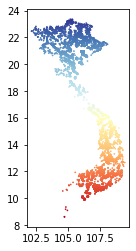

In [26]:
ax = nodes.plot(column="distance_to_closest", cmap="RdYlBu", markersize=0.5)

In [27]:
hospitals['node_id'] = 0

In [28]:
nodes["node_id"] = nodes.index

In [29]:
closest = nearest_neighbor(pop,nodes,return_dist=True)

In [30]:
closest

,y,x,gridcode,highway,geometry,distance_to_closest,node_id,distance
0,23.361695,105.318230,0.0,NaN,POINT (105.31823 23.36169),23.361695,2522145872,1001.992361
1,23.310491,105.296753,0.0,NaN,POINT (105.29675 23.31049),23.310491,7968676755,2259.617990
2,23.361695,105.318230,0.0,NaN,POINT (105.31823 23.36169),23.361695,2522145872,1858.869236
3,23.361695,105.318230,0.0,NaN,POINT (105.31823 23.36169),23.361695,2522145872,1076.340540
4,23.361695,105.318230,0.0,NaN,POINT (105.31823 23.36169),23.361695,2522145872,760.847273
...,...,...,...,...,...,...,...,...
406779,9.088821,104.949814,0.0,NaN,POINT (104.94981 9.08882),9.088821,4889311487,16063.958677
406780,8.605079,104.722659,0.0,NaN,POINT (104.72266 8.60508),8.605079,2667131347,11767.363701
406781,8.605079,104.722659,0.0,NaN,POINT (104.72266 8.60508),8.605079,2667131347,12689.396156
406782,8.605079,104.722659,0.0,NaN,POINT (104.72266 8.60508),8.605079,2667131347,13612.052257


In [31]:
#closest['node_id'] = closest.index

In [32]:
pop["node_id"] = closest["node_id"]
pop["distance_to_closest_node"] = closest["distance"]

In [33]:
pop

,x,y,Z,geometry,node_id,distance_to_closest_node
0,105.319583,23.395417,56.801758,POINT (105.31958 23.39542),2522145872,1001.992361
1,105.294583,23.387083,69.821190,POINT (105.29458 23.38708),7968676755,2259.617990
2,105.302916,23.387083,61.812702,POINT (105.30292 23.38708),2522145872,1858.869236
3,105.311250,23.387083,50.627831,POINT (105.31125 23.38708),2522145872,1076.340540
4,105.319583,23.387083,87.299217,POINT (105.31958 23.38708),2522145872,760.847273
...,...,...,...,...,...,...
406779,104.894583,8.570417,17.621071,POINT (104.89458 8.57042),4889311487,16063.958677
406780,104.827916,8.562083,16.502373,POINT (104.82792 8.56208),2667131347,11767.363701
406781,104.836250,8.562083,31.207506,POINT (104.83625 8.56208),2667131347,12689.396156
406782,104.844583,8.562083,29.299860,POINT (104.84458 8.56208),2667131347,13612.052257


In [34]:
access = pop.merge(nodes[["distance_to_closest", "node_id"]], on="node_id")

In [35]:
# Add the (Euclidean) distance between building 
# and the closest node in the road network to get a full "door-to-door" distance
access["distance"] = access["distance_to_closest"] + access["distance_to_closest_node"]

# Calculate distance in kilometers (meters by default)
access["distance_km"] = (access["distance"] / 1000).round(1)

In [36]:
access.head(2)

,x,y,Z,geometry,node_id,distance_to_closest_node,distance_to_closest,distance,distance_km
0,105.319583,23.395417,56.801758,POINT (105.31958 23.39542),2522145872,1001.992361,23.361695,1025.354055,1.0
1,105.302916,23.387083,61.812702,POINT (105.30292 23.38708),2522145872,1858.869236,23.361695,1882.230931,1.9


In [37]:
# Classify distances to every 2 km zones, specify that the upper boundary is 50 kilometer
# everything above this will be put into a same class
upper_boundary_distance = 10
width = 1

# Use self-defined classification
classifier = mc.UserDefined(access["distance_km"], bins=[x for x in range(0, int(upper_boundary_distance)+1, width)])
access["cls"] = access[["distance_km"]].apply(classifier)
# Replace the class numbers to distance categories (e.g. 0-2, 2-4 .. km etc.)
access["travel_distance"] = access["cls"].replace({k: v 
                                                   for k, v in 
                                                   zip([x for x in range(len(classifier.bins))], 
                                                       classifier.bins)})

# Set all values over 50 km as 51 (to improve how the colorscale works)
access.loc[access["travel_distance"] > upper_boundary_distance, "travel_distance"] = upper_boundary_distance + 1

# Convert the observation counts as percentages
classifier.counts = (classifier.counts / classifier.counts.sum()).round(3)

# Convert stats to dataframe
bins = classifier.bins.astype(int)
categories = np.vstack([bins[:-1], bins[1:]]).T
categories = [f"{low}-{high}" for low, high in categories]
access_zone_classes = pd.DataFrame({"Distance": categories, "% of pop nodes": classifier.counts[1:]})

In [38]:
access['Zpct'] = (access.Z / access.Z.sum())*100

In [39]:
# percentage of people living further away than 2km
access[access['distance_km'] <= 1]['Zpct'].sum()

12.89141863567261

In [40]:
access[access['cls']==10]

,x,y,Z,geometry,node_id,distance_to_closest_node,distance_to_closest,distance,distance_km,cls,travel_distance,Zpct
599,105.486250,23.020417,95.776009,POINT (105.48625 23.02042),611579190,9114.471091,23.161017,9137.632108,9.1,10,10.0,0.000098
609,105.486250,23.012083,111.753784,POINT (105.48625 23.01208),611579190,9229.877644,23.161017,9253.038661,9.3,10,10.0,0.000115
619,105.486250,23.003750,83.141487,POINT (105.48625 23.00375),611579190,9350.377816,23.161017,9373.538833,9.4,10,10.0,0.000085
629,105.486250,22.995417,57.171822,POINT (105.48625 22.99542),611579190,9475.777284,23.161017,9498.938301,9.5,10,10.0,0.000059
656,105.477916,22.970417,44.267193,POINT (105.47792 22.97042),611579190,9133.509516,23.161017,9156.670533,9.2,10,10.0,0.000045
...,...,...,...,...,...,...,...,...,...,...,...,...
406712,104.811250,8.603750,93.407043,POINT (104.81125 8.60375),2667131347,9850.851875,8.605079,9859.456954,9.9,10,10.0,0.000096
406730,104.811250,8.595417,101.030464,POINT (104.81125 8.59542),2667131347,9854.585336,8.605079,9863.190414,9.9,10,10.0,0.000104
406745,104.811250,8.587083,76.728729,POINT (104.81125 8.58708),2667131347,9863.974241,8.605079,9872.579320,9.9,10,10.0,0.000079
406756,104.811250,8.578750,70.985229,POINT (104.81125 8.57875),2667131347,9879.002467,8.605079,9887.607546,9.9,10,10.0,0.000073


In [41]:
round(access.groupby('cls')['Zpct'].sum(),1)

cls
0      0.1
1     12.8
2     10.3
3      8.8
4      8.0
5      8.1
6      8.1
7      7.4
8      6.5
9      5.0
10     3.5
11    21.3
Name: Zpct, dtype: float64

In [42]:
access_zone_classes

,Distance,% of pop nodes
0,0-1,0.122
1,1-2,0.172
2,2-3,0.156
3,3-4,0.125
4,4-5,0.098
5,5-6,0.075
6,6-7,0.055
7,7-8,0.040
8,8-9,0.029
9,9-10,0.021


In [43]:
pd.DataFrame(access.groupby('cls')['Zpct'].sum()).reset_index().merge(access_zone_classes['Distance'],left_index=True,right_index=True)

,cls,Zpct,Distance
0,0,0.110582,0-1
1,1,12.780837,1-2
2,2,10.294809,2-3
3,3,8.835789,3-4
4,4,8.013692,4-5
5,5,8.138849,5-6
6,6,8.131738,6-7
7,7,7.400578,7-8
8,8,6.459879,8-9
9,9,5.047926,9-10


In [44]:
# Say, "the default sans-serif font is COMIC SANS"
plt.rcParams['font.sans-serif'] = "Helvetica"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"

(0.0, 80.0)

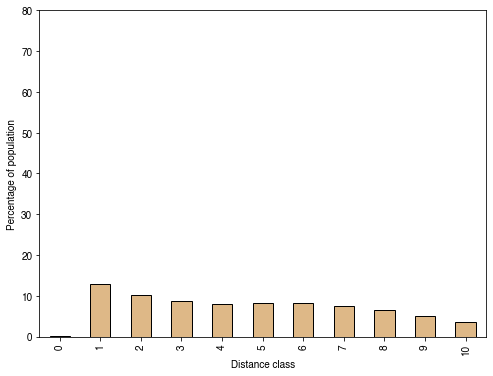

In [45]:
fig, ax = plt.subplots(figsize=(8,6))
pd.DataFrame(access.groupby('cls')['Zpct'].sum()).reset_index().merge(access_zone_classes['Distance'],left_index=True,right_index=True)['Zpct'].plot(x='cls',kind='bar',color='burlywood',ax=ax,edgecolor='black')
plt.xlabel("Distance class")
plt.ylabel("Percentage of population")
ax.set_ylim([0,80])
#plt.savefig('20210930_PeopleRangeScenario0.svg',format='svg')
#plt.savefig('20210930_PeopleRangeScenario0.eps',format='eps')

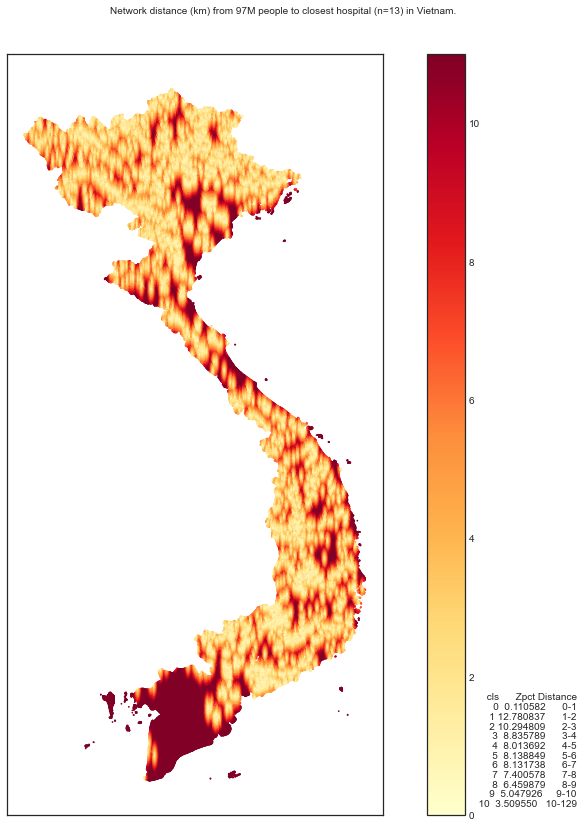

In [46]:
plt.style.use('seaborn-white')

fig, ax = plt.subplots(figsize=(16,14))
access.plot(ax=ax,column="travel_distance", markersize=0.5, legend=True, cmap="YlOrRd", figsize=(17,10))

ax.tick_params(
    axis='both', bottom=False, left=False,         
    labelbottom=False, labelleft=False) 

# Adjust the map extent
#ax.set_xlim(22.5, 30.5)
#ax.set_ylim(57.4, 59.9)
# Add some useful info
ax.text(x=104, y=25, s=f"Network distance (km) from {round(pop['Z'].sum()/1000000)}M people to closest hospital (n={src_cnt}) in Vietnam.")
ax.text(x=114,y=8, s=pd.DataFrame(access.groupby('cls')['Zpct'].sum()).reset_index().merge(access_zone_classes['Distance'],left_index=True,right_index=True).to_string(index=False),
        ha='right', linespacing=1.1);

#plt.savefig('20210930_NetworkDistanceScenarioScenario0.svg',format='svg')
#plt.savefig('20210930_NetworkDistanceScenarioScenario0.eps',format='eps')
#plt.savefig('20210930_NetworkDistanceScenarioScenario0.png')

In [49]:
floodrisk.head(2)

,FID_Raster,Id,gridcode,FID_countr,country,SUM_Shape_,Shape_Leng,Shape_Area,geometry
0,50415,50415,2,1,1,27.979371,0.063806,0.000183,"POLYGON Z ((104.91667 23.17635 0.00000, 104.91..."
1,50416,50416,3,1,1,27.979371,0.225159,0.001632,"MULTIPOLYGON Z (((105.00000 23.16667 0.00000, ..."


<AxesSubplot:>

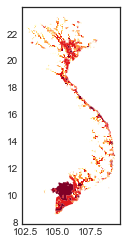

In [51]:
floodrisk.plot(column='gridcode',cmap='YlOrRd')

<AxesSubplot:>

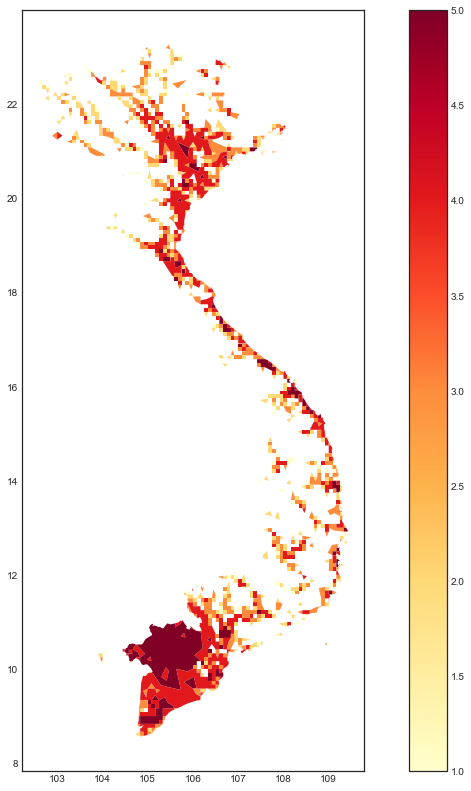

In [52]:
plt.style.use('seaborn-white')

fig, ax1 = plt.subplots(figsize=(16,14))
#access.plot(ax=ax,column="travel_distance", markersize=0.5, legend=True, cmap="YlOrRd", figsize=(17,10))
floodrisk.plot(ax=ax1,column='gridcode',cmap='YlOrRd',legend=True)

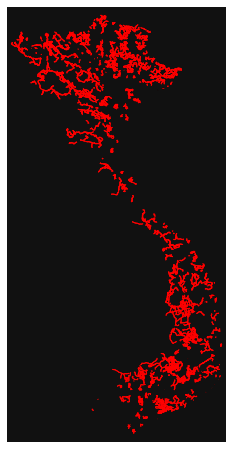

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [54]:
ox.plot_graph(G=G,node_size=0,edge_color='red')

<AxesSubplot:>

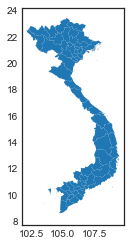

<AxesSubplot:>

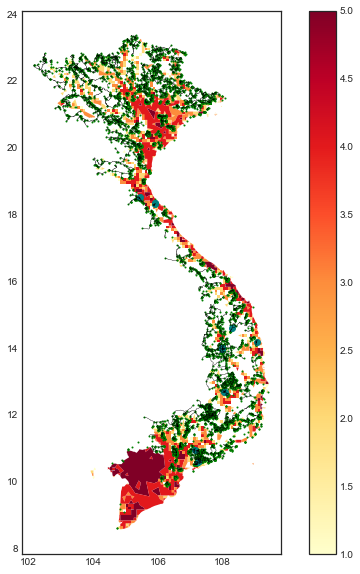

In [153]:
base = floodrisk.plot(column='gridcode',alpha=1,figsize=(10,10),lw=0.5,legend=True,cmap='YlOrRd');

edges.plot(ax=base,color='black',figsize=(10,10),lw=0.2)
nodes.plot(ax=base,markersize=1,color='green')
hospitals.plot(ax=base,color='teal')


<AxesSubplot:>

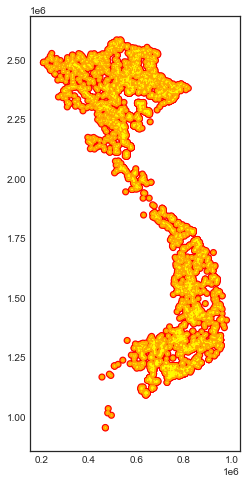

In [174]:
ax2 = nodes.to_crs("EPSG:3405").buffer(15000).plot(figsize=(8,8),color='red')
nodes.to_crs("EPSG:3405").buffer(10000).plot(ax=ax2,figsize=(8,8),color='orange')
nodes.to_crs("EPSG:3405").buffer(2000).plot(ax=ax2,figsize=(8,8),color='yellow')

In [144]:
access['Zpct'].sum()

100.0

In [157]:
nodes

,y,x,gridcode,highway,geometry,distance_to_closest,node_id
osmid,,,,,,,
91670279,10.953034,107.003998,0.0,NaN,POINT (107.00400 10.95303),10.953034,91670279
675999845,10.952945,107.004044,0.0,NaN,POINT (107.00404 10.95294),10.952945,675999845
7926615338,10.953181,107.004003,0.0,NaN,POINT (107.00400 10.95318),10.953181,7926615338
91674481,10.916534,107.421282,0.0,NaN,POINT (107.42128 10.91653),10.916534,91674481
1627220281,10.917397,107.420390,0.0,NaN,POINT (107.42039 10.91740),10.917397,1627220281
...,...,...,...,...,...,...,...
8035674099,14.478884,108.214588,0.0,NaN,POINT (108.21459 14.47888),14.478884,8035674099
3548486132,21.435217,107.965559,0.0,NaN,POINT (107.96556 21.43522),21.435217,3548486132
4885194234,12.918188,107.821479,0.0,NaN,POINT (107.82148 12.91819),12.918188,4885194234


<AxesSubplot:>

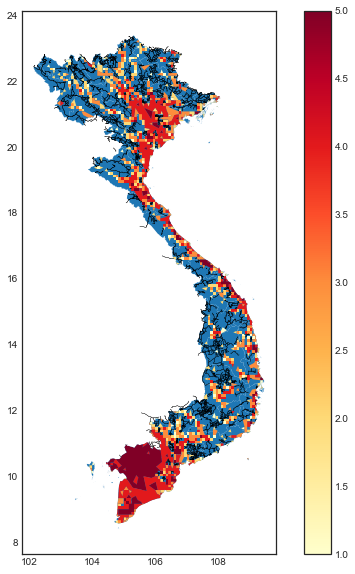

In [189]:
ax3 = vietnamBoundaries.dissolve(by='GID_1').plot(figsize=(10,10))
floodrisk.plot(ax=ax3,column='gridcode',alpha=1,figsize=(10,10),lw=0.5,legend=True,cmap='YlOrRd')
edges.plot(ax=ax3,color='black',lw=0.3)


<AxesSubplot:>

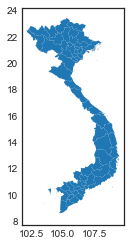

In [104]:
from shapely.geometry import Point, Polygon
from descartes import PolygonPatch